In [63]:
import torch
import matplotlib.pyplot as plt

# Dataset Prep

In [70]:
X = torch.ones(100, 100)-.1 - torch.randn(100, 100)*.01

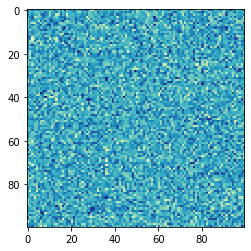

In [71]:
plt.imshow(X, cmap='YlGnBu', interpolation='nearest')

In [72]:
X

tensor([[0.9189, 0.8981, 0.9134,  ..., 0.8965, 0.9057, 0.9137],
        [0.9032, 0.8957, 0.8979,  ..., 0.9043, 0.9004, 0.8912],
        [0.9090, 0.8982, 0.9091,  ..., 0.9022, 0.9008, 0.9072],
        ...,
        [0.8726, 0.8990, 0.9100,  ..., 0.8991, 0.9159, 0.8972],
        [0.9099, 0.9057, 0.9041,  ..., 0.8905, 0.9042, 0.8920],
        [0.9050, 0.9102, 0.9197,  ..., 0.8895, 0.9268, 0.9161]])

# Dataset class

In [73]:
from torch.utils.data.dataset import Dataset

class MyCustomDataset(Dataset):
    
    def __init__(self, x):
        self.x = x
        
    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return len(self.x)

In [74]:
dataset = MyCustomDataset(X)

# DataLoader

In [75]:
from torch.utils.data import DataLoader

batch_size = len(dataset)

train_loader = DataLoader(dataset, batch_size, shuffle=True)

# Discriminator

In [76]:
class Discriminator(torch.nn.Module):
  def __init__(self, input_size):
    super(Discriminator, self).__init__()
    self.disc = torch.nn.Sequential(
        torch.nn.Linear(input_size, int(input_size/2.)),
        torch.nn.Sigmoid(),
        torch.nn.Linear(int(input_size/2.), 1),
        torch.nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.disc(x)

In [77]:
D = Discriminator(100)

# Generator

In [78]:
class Generator(torch.nn.Module):
  def __init__(self, z_dim, img_dim):
    super(Generator, self).__init__()
    self.gen = torch.nn.Sequential(
        torch.nn.Linear(z_dim, 50),
        torch.nn.Sigmoid(),
        torch.nn.Linear(50, img_dim),
        torch.nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.gen(x)

In [79]:
G = Generator(15, 100)

In [80]:
z_dim = 15

In [99]:
fixed_noise = torch.rand((100, z_dim))

In [89]:
optimizerD = torch.optim.Adam(D.parameters(), lr=.0001)
optimizerG = torch.optim.Adam(G.parameters(), lr=.0001)
criterion = torch.nn.BCELoss()

In [90]:
LOSSES_D = []
LOSSES_G = []
for epoch in range(3000):
  for real in train_loader:
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    outputs = D(real)
    d_loss_real = criterion(outputs, real_labels)

    z = torch.rand(batch_size, z_dim)
    fake_images = G(z)

    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)

    d_loss = d_loss_real + d_loss_fake
    LOSSES_D.append(d_loss.item())

    optimizerD.zero_grad()
    d_loss.backward()
    optimizerD.step()



    z = torch.rand(batch_size, z_dim)
    fake_images = G(z)

    outputs = D(fake_images)

    loss_g = criterion(outputs, real_labels)
    LOSSES_G.append(loss_g.item())

    optimizerG.zero_grad()
    loss_g.backward()
    optimizerG.step()


In [91]:
fake_images

tensor([[0.8897, 0.8982, 0.9318,  ..., 0.8645, 0.7544, 0.8279],
        [0.8709, 0.8846, 0.9164,  ..., 0.8436, 0.7407, 0.8119],
        [0.8732, 0.8846, 0.9210,  ..., 0.8520, 0.7398, 0.8242],
        ...,
        [0.8799, 0.8929, 0.9216,  ..., 0.8534, 0.7371, 0.8159],
        [0.8851, 0.8981, 0.9296,  ..., 0.8671, 0.7513, 0.8307],
        [0.8808, 0.8893, 0.9274,  ..., 0.8595, 0.7514, 0.8218]],
       grad_fn=<SigmoidBackward>)

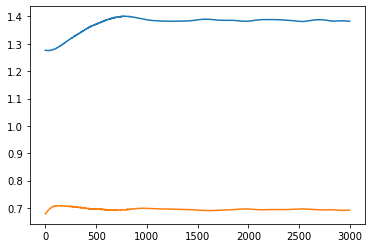

In [92]:
import matplotlib.pyplot as plt
plt.plot(LOSSES_D)
plt.plot(LOSSES_G)

In [100]:
with torch.no_grad():
  y = G(fixed_noise)

In [101]:
y

tensor([[0.8788, 0.8928, 0.9218,  ..., 0.8563, 0.7490, 0.8191],
        [0.8711, 0.8833, 0.9179,  ..., 0.8526, 0.7372, 0.8130],
        [0.8834, 0.8942, 0.9280,  ..., 0.8651, 0.7526, 0.8285],
        ...,
        [0.8657, 0.8782, 0.9106,  ..., 0.8434, 0.7300, 0.8076],
        [0.8804, 0.8902, 0.9255,  ..., 0.8595, 0.7434, 0.8270],
        [0.8855, 0.8949, 0.9287,  ..., 0.8669, 0.7479, 0.8255]])

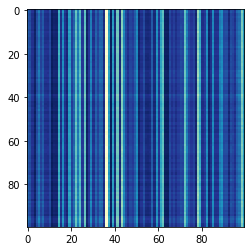

In [103]:
plt.imshow(y.numpy(), cmap='YlGnBu', interpolation='nearest')